In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# import os
# os.listdir()

In [3]:
imgs = torch.load("linear_imgs.pt")

In [4]:
imgs = imgs.squeeze(1)

In [5]:
imgs.shape

torch.Size([10000, 76, 77])

In [6]:
imgs[0].max()

tensor(1.)

In [7]:
# plt.imshow(sample_imgs[3])

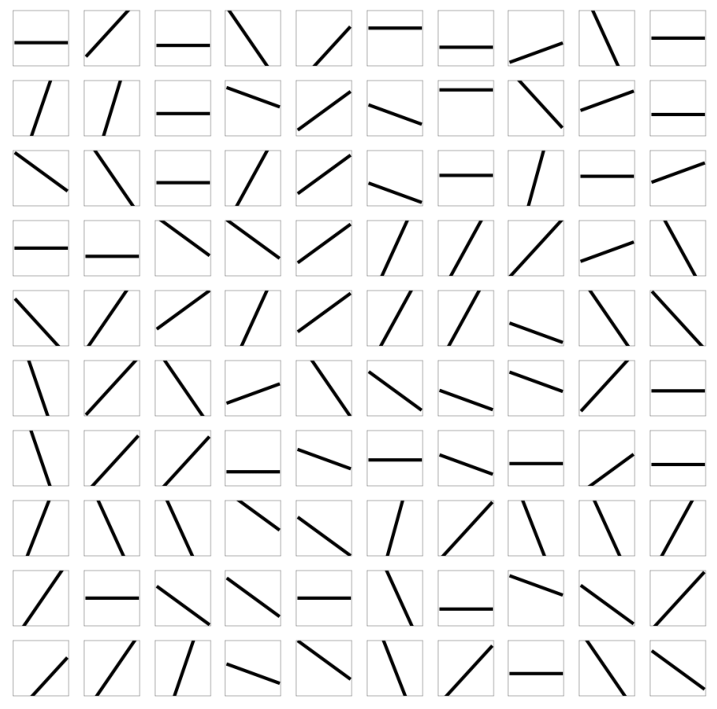

In [8]:
# num_samples = 25
sample_imgs = [i for i in imgs]

fig = plt.figure(figsize=(9, 9))
grid = ImageGrid(fig, 111, nrows_ncols=(10,10), axes_pad=0.1)

for ax, im in zip(grid, sample_imgs):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
plt.show()

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

mps


In [250]:
dataset = TensorDataset(imgs)
batch_size = 2048 # 128 works really well
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [251]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode = nn.Sequential(
            nn.Linear(76 * 77, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
        )
        
        self.log_var_layer = nn.Sequential(
            nn.Linear(128, 2)
        )
        
        self.mean_layer = nn.Sequential(
            nn.Linear(128, 2)
        )
        
        self.decode = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 76*77),
            nn.Sigmoid()
        )
        
    def get_latent(self, encoded_x):
        log_var = self.log_var_layer(encoded_x)
        mean = self.log_var_layer(encoded_x)
        
        epsilon = torch.randn_like(log_var).to(device)
        
        z = mean + log_var * epsilon
        return z, mean, log_var
    
    def forward(self, x):
        x = x.view(-1, 76*77)
        encoded = self.encode(x)
        z, mean, logvar = self.get_latent(encoded)
        logits = self.decode(z)
        
        return logits, mean, logvar

In [252]:
model = NeuralNetwork().to(device)

In [253]:
print(model)

NeuralNetwork(
  (encode): Sequential(
    (0): Linear(in_features=5852, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (log_var_layer): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
  )
  (mean_layer): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
  )
  (decode): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=5852, bias=True)
    (5): Sigmoid()
  )
)


In [255]:
mse = nn.MSELoss()
def loss_and_regularization(pred, target, mean, logvar):
#     pred_loss = torch.sum((pred - target)**2)
    pred_loss = mse(pred, target)

#     regularization_loss = -0.0005 * torch.sum(1 + logvar - mean**2- torch.exp(logvar))
    regularization_loss = -0.000000005 * torch.sum(1+ logvar - mean.pow(2) - logvar.exp())


    return pred_loss + regularization_loss



In [256]:
loss_fn = loss_and_regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [257]:
def train(data, model, loss_fn, optimizer, id):
    size = len(data)
    model.train()
    loss_total = 0

    for x in dataloader:
        x = x[0].to(device)
        
        pred, mean, logvar = model(x)
        loss = loss_fn(pred, x.view(-1, 76*77), mean, logvar)
        loss_total += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if (id % 50 == 0):
        print(loss_total)
    

In [258]:
train(imgs, model, loss_fn, optimizer, 1)

In [259]:
for i in range(1000):
    train(imgs, model, loss_fn, optimizer, i)

0.4964747205376625
0.22757763415575027
0.21193640306591988
0.20338107645511627
0.1946191005408764
0.19278910011053085
0.19004016742110252
0.187906913459301
0.1864665001630783
0.18500126525759697
0.18578648939728737


KeyboardInterrupt: 

In [260]:
to_print = []

for i in range(50):
    pred, _, _ = model(imgs[i].to(device))
    pred = pred.view(76,77)
    to_print += [imgs[i], pred.to("cpu").detach().numpy()]

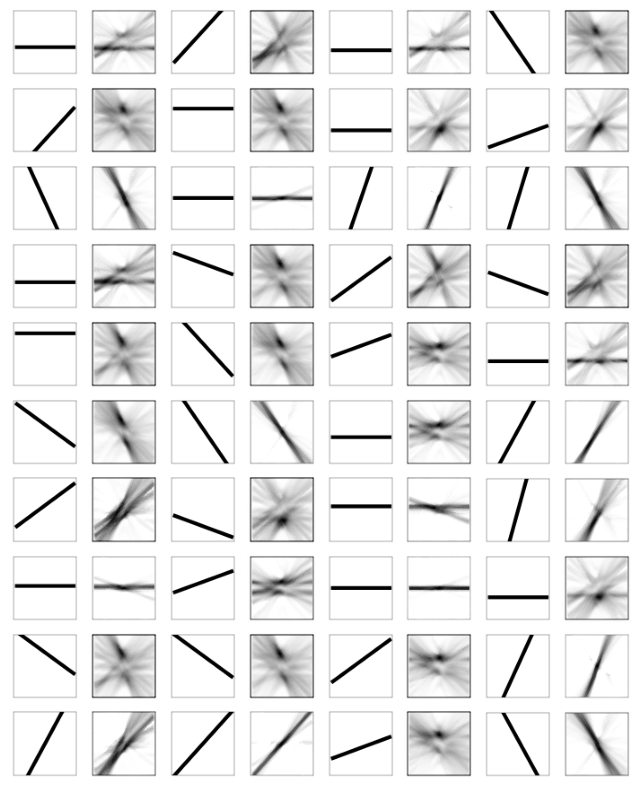

In [261]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(10,8), axes_pad=0.1)

for ax, im in zip(grid, to_print):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
plt.show()

In [262]:
inputs = [
    torch.tensor([10.0, 0.0]),
    torch.tensor([0.0, 10.0]),
    torch.tensor([10.0, 10.0]),
    torch.tensor([-10.0, 0]),
    torch.tensor([-10.0, -10.0]),
    torch.tensor([0.0, -10.0]),
    torch.tensor([10.0, -10.0]),
    torch.tensor([-10.0, 10.0]),
]

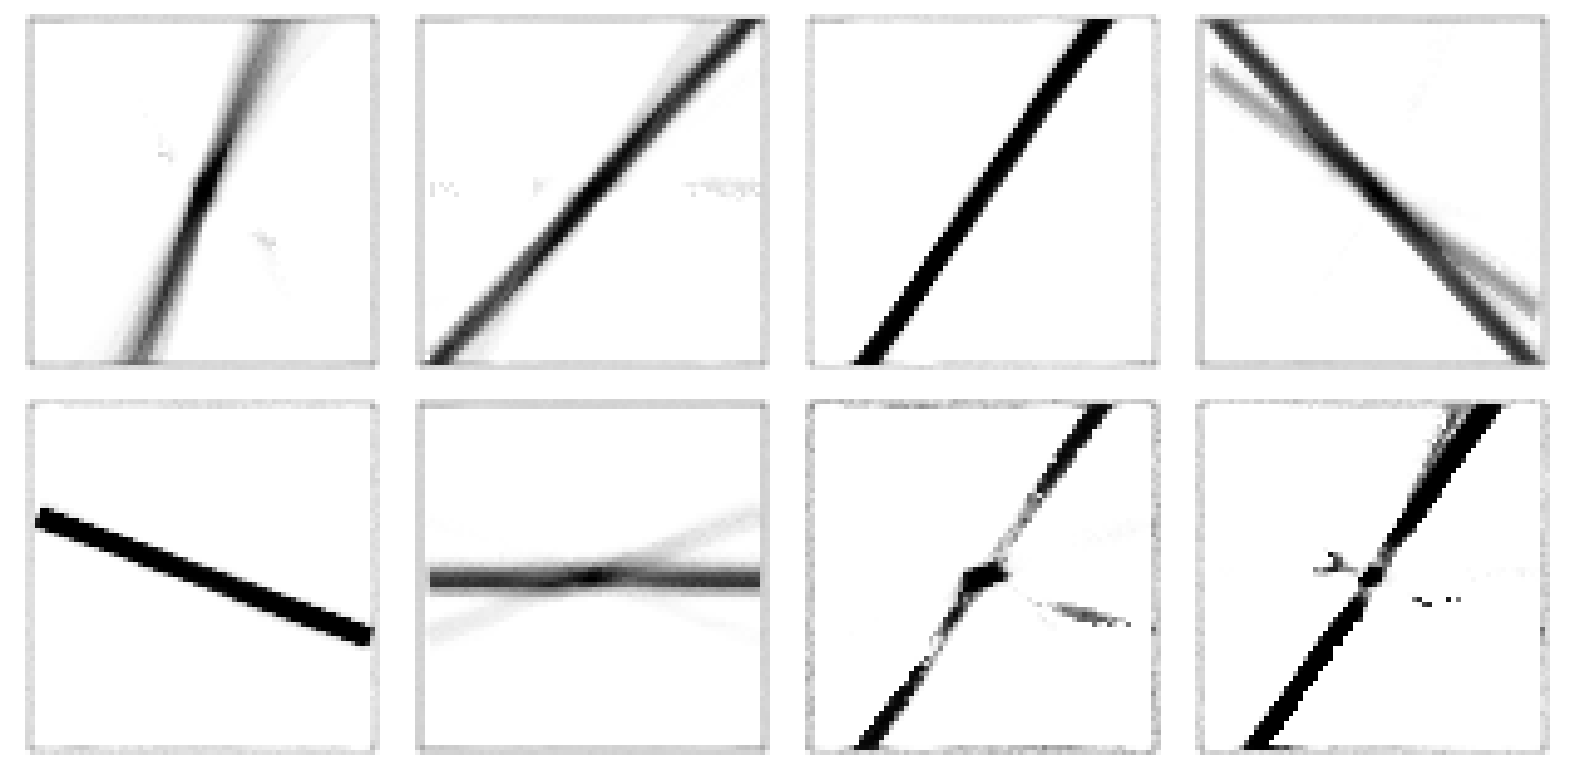

In [263]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.1)

for ax, im in zip(grid, inputs):
    pred = model.decode(im.to(device))
    pred = pred.view(76,77)
    ax.imshow(pred.to("cpu").detach().numpy(), cmap='gray')
    ax.axis('off')
plt.show()

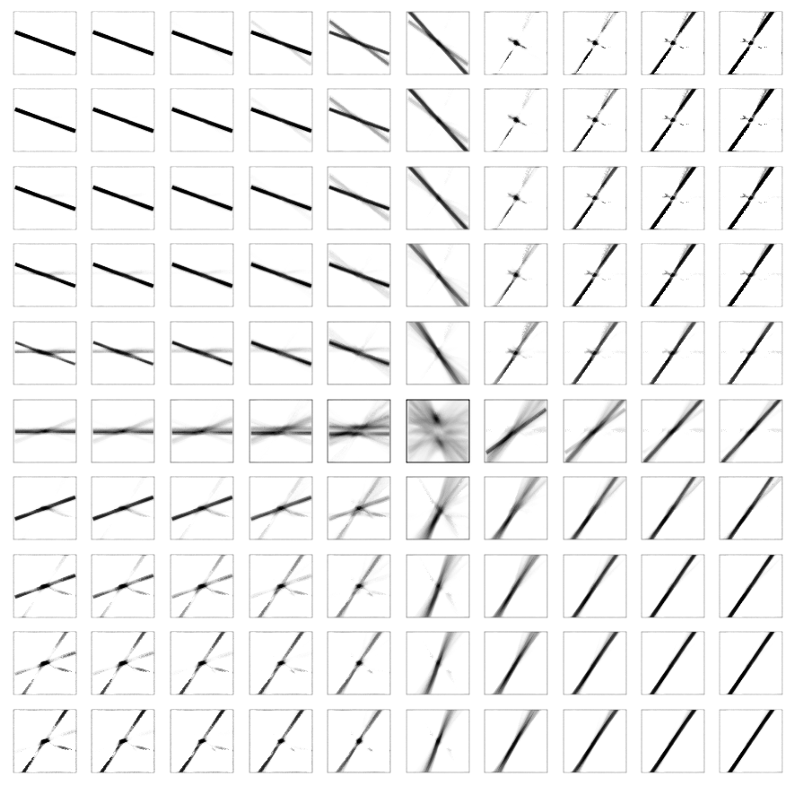

In [264]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(10,10), axes_pad=0.1)

to_graph = []
for i in np.arange(-10, 10.0, 2):
    for j in np.arange(-10, 10.0, 2):
        latent = torch.tensor([i,j]).float()
        pred = model.decode(latent.to(device))
        pred = pred.view(76, 77).detach().cpu().numpy()
        to_graph.append(pred)



for ax, im in zip(grid, to_graph):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
plt.show()

In [ ]:
import numpy as np

In [107]:
plot_latent_space(model)

ValueError: could not broadcast input array from shape (76,77) into shape (76,52)